In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import sklearn
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
print(sklearn.__version__)

1.3.0


## Read Files

In [3]:
csv_folder = 'C:/Users/Neil/OneDrive/Documents/Capstone Files/' ### make sure na lahat ng csv ay nasa isang folder tapos dapat yung features lang yung nandun
csv_files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))  # Get all CSV files

In [4]:
csv_files

['C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M1-24.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M13-36.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M25-48.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M37-60.csv']

## Splitting

In [5]:
selected_features = [
    'EverAtLeast1DPD_3mos', 
    'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 
    'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 
    'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 
    'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 
    'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 
    'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 
    'WorstDel_9mos', 'WorstDel_12mos', 
    'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 
    'Partial_past3mos', 
    'Full_past3mos', 'Missed_past6mos', 
    'Partial_past6mos', 
    'Full_past6mos', 
    'Missed_past9mos', 
    'Partial_past9mos', 
    'Full_past9mos', 'Missed_past12mos', 
    'Partial_past12mos', 
    'Full_past12mos'
]


# Lists to store all training and testing data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Process each CSV file
for file in csv_files:
    print(f"\nProcessing file: {file}")
    
    # Read the CSV file
    data = pd.read_csv(file)

    X = data[selected_features]
    y = data['DEFAULT_TAGGING']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Append to lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    # Print class balance
    print("Train class balance:\n", y_train.value_counts(normalize=True))
    print("Test class balance:\n", y_test.value_counts(normalize=True))

# Merge all train and test data
X_train_all = pd.concat(X_train_list, axis=0)
X_test_all = pd.concat(X_test_list, axis=0)
y_train_all = pd.concat(y_train_list, axis=0)
y_test_all = pd.concat(y_test_list, axis=0)

print("\nFinal Merged Data Shapes:")
print("X_train_all:", X_train_all.shape)
print("X_test_all:", X_test_all.shape)
print("y_train_all:", y_train_all.shape)
print("y_test_all:", y_test_all.shape)


Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M1-24.csv
Train class balance:
 DEFAULT_TAGGING
0    0.998525
1    0.001475
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.998513
1    0.001487
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M13-36.csv
Train class balance:
 DEFAULT_TAGGING
0    0.994214
1    0.005786
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.994182
1    0.005818
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M25-48.csv
Train class balance:
 DEFAULT_TAGGING
0    0.986499
1    0.013501
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.98652
1    0.01348
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M37-60.csv
Train class balance:
 DEFAULT_TAGGING
0    0.974224


In [6]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.3, random_state=42, stratify=y_train_all
)

print("\nFinal Split Data Shapes:")
print("X_train_split:", X_train_split.shape)
print("X_val:", X_val.shape)
print("y_train_split:", y_train_split.shape)
print("y_val:", y_val.shape)


Final Split Data Shapes:
X_train_split: (78197, 33)
X_val: (33514, 33)
y_train_split: (78197,)
y_val: (33514,)


#### Option 1 Grid Search 

In [7]:
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve
import lightgbm as lgb
import numpy as np
from itertools import product

def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity
#change param_grid based on your chosen range of value
def grid_search_lgbm(X_train_split, y_train_split, X_val, y_val):
    param_grid = {
        'num_leaves': np.linspace(20, 100, 5, dtype=int),
        'learning_rate': np.linspace(0.03, 0.15, 5),
        'num_iterations': np.linspace(50, 200, 4, dtype=int)
    }

    best_results = {
        'recall': {'score': -np.inf, 'params': None},
        'specificity': {'score': -np.inf, 'params': None}
    }

    print("Starting Grid Search for num_leaves, learning_rate, and num_iterations...\n")

    for num_leaves, learning_rate, num_iterations in product(
        param_grid['num_leaves'], param_grid['learning_rate'], param_grid['num_iterations']
    ):
        model = lgb.LGBMClassifier(
            boosting_type='gbdt',
            objective='binary',
            metric='binary_logloss',
            learning_rate=learning_rate,
            num_iterations=num_iterations,
            num_leaves=num_leaves,
            is_unbalanced=True,
            random_state=42,
            bagging_seed=42,
            feature_fraction_seed=42,
            drop_seed=42,
            data_random_seed=42,
            deterministic=True,
            n_jobs=1
        )

        model.fit(X_train_split, y_train_split)
        y_proba = model.predict_proba(X_val)

        # Threshold tuning based on maximum F1 score
        precision, recall_arr, thresholds = precision_recall_curve(y_val, y_proba[:, 1])
        f1_scores = 2 * (precision * recall_arr) / (precision + recall_arr)  # Avoid divide-by-zero
        optimal_threshold = thresholds[np.argmax(f1_scores)]

        # Apply optimal threshold
        y_pred = (y_proba[:, 1] >= optimal_threshold).astype(int)

        recall = recall_score(y_val, y_pred)
        specificity = calculate_specificity(y_val, y_pred)

        print(f"Params: num_leaves={num_leaves}, learning_rate={learning_rate:.3f}, num_iterations={num_iterations}")
        print(f" → Optimal Threshold: {optimal_threshold:.4f}")
        print(f" → Recall: {recall:.4f}, Specificity: {specificity:.4f}\n")

        if recall > best_results['recall']['score']:
            best_results['recall'] = {
                'score': recall,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

        if specificity > best_results['specificity']['score']:
            best_results['specificity'] = {
                'score': specificity,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

    # Print final best results
    print("Grid Search Complete!\n")
    print("Best Recall Score:")
    print(f" → Score: {best_results['recall']['score']:.4f}")
    print(f" → Params: {best_results['recall']['params']}\n")

    print("Best Specificity Score:")
    print(f" → Score: {best_results['specificity']['score']:.4f}")
    print(f" → Params: {best_results['specificity']['params']}\n")

    return best_results

In [8]:
results = grid_search_lgbm(X_train_split, y_train_split, X_val, y_val)
print(results)

Starting Grid Search for num_leaves, learning_rate, and num_iterations...

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=20, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.3482
 → Recall: 0.7653, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=20, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.3476
 → Recall: 0.7840, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 47
True Positives (TP): 166
Params: num_leaves=20, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.3785
 → Recall: 0.7793, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 44
True Positives (TP): 169
Params: num_leaves=20, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.2755
 → Recall: 0.7934, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=20, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.5810
 → Recall: 0.7559, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=20, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.5345
 → Recall: 0.7512, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=20, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.4663
 → Recall: 0.7559, Specificity: 0.9997



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=20, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.3401
 → Recall: 0.7746, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=20, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.5880
 → Recall: 0.7277, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 55
True Positives (TP): 158
Params: num_leaves=20, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.5289
 → Recall: 0.7418, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=20, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.4728
 → Recall: 0.7559, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=20, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.7737
 → Recall: 0.7230, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-thr

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33284
False Positives (FP): 17
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=20, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.5440
 → Recall: 0.6995, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=20, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.5190
 → Recall: 0.7042, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=20, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.8615
 → Recall: 0.6854, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=20, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.8224
 → Recall: 0.6901, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=20, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9867
 → Recall: 0.6854, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33278
False Positives (FP): 23
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=20, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.7512
 → Recall: 0.6901, Specificity: 0.9993

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=20, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 1.0000
 → Recall: 0.6808, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33281
False Positives (FP): 20
False Negatives (FN): 69
True Positives (TP): 144
Params: num_leaves=20, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 1.0000
 → Recall: 0.6761, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=40, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.2516
 → Recall: 0.7840, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=40, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.3209
 → Recall: 0.7840, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=40, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.4831
 → Recall: 0.7465, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalan

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=40, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.4468
 → Recall: 0.7606, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33284
False Positives (FP): 17
False Negatives (FN): 47
True Positives (TP): 166
Params: num_leaves=40, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.3616
 → Recall: 0.7793, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 47
True Positives (TP): 166
Params: num_leaves=40, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.3441
 → Recall: 0.7793, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33284
False Positives (FP): 17
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=40, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.3260
 → Recall: 0.7746, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=40, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.4337
 → Recall: 0.7700, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=40, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.4721
 → Recall: 0.7746, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33280
False Positives (FP): 21
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=40, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.3402
 → Recall: 0.7606, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=40, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.6350
 → Recall: 0.7512, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=40, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.4632
 → Recall: 0.7606, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=40, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9644
 → Recall: 0.6995, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=40, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9997
 → Recall: 0.7183, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33258
False Positives (FP): 43
False Negatives (FN): 76
True Positives (TP): 137
Params: num_leaves=40, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 1.0000
 → Recall: 0.6432, Specificity: 0.9987

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-th

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33274
False Positives (FP): 27
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=40, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 1.0000
 → Recall: 0.6854, Specificity: 0.9992

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=40, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9864
 → Recall: 0.7230, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 71
True Positives (TP): 142
Params: num_leaves=40, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9864
 → Recall: 0.6667, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=40, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9876
 → Recall: 0.6995, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-th

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33244
False Positives (FP): 57
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=40, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 1.0000
 → Recall: 0.6808, Specificity: 0.9983

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=60, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.3164
 → Recall: 0.7746, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=60, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.4553
 → Recall: 0.7512, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=60, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.4869
 → Recall: 0.7465, Specificity: 0.9998



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=60, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.4557
 → Recall: 0.7606, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33278
False Positives (FP): 23
False Negatives (FN): 43
True Positives (TP): 170
Params: num_leaves=60, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.3155
 → Recall: 0.7981, Specificity: 0.9993

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33284
False Positives (FP): 17
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=60, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.4339
 → Recall: 0.7606, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=60, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.4639
 → Recall: 0.7512, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=60, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.4113
 → Recall: 0.7606, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33275
False Positives (FP): 26
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=60, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.3374
 → Recall: 0.7840, Specificity: 0.9992

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33284
False Positives (FP): 17
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=60, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.4578
 → Recall: 0.7230, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=60, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.7578
 → Recall: 0.6948, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-th

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=60, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.5867
 → Recall: 0.7042, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=60, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.8722
 → Recall: 0.7042, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=60, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9524
 → Recall: 0.7089, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-th

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=60, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9924
 → Recall: 0.7183, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33281
False Positives (FP): 20
False Negatives (FN): 57
True Positives (TP): 156
Params: num_leaves=60, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9500
 → Recall: 0.7324, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 61
True Positives (TP): 152
Params: num_leaves=60, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.8103
 → Recall: 0.7136, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=60, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.8783
 → Recall: 0.7089, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33193
False Positives (FP): 108
False Negatives (FN): 61
True Positives (TP): 152
Params: num_leaves=60, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9922
 → Recall: 0.7136, Specificity: 0.9968

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33227
False Positives (FP): 74
False Negatives (FN): 73
True Positives (TP): 140
Params: num_leaves=60, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 1.0000
 → Recall: 0.6573, Specificity: 0.9978

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 48
True Positives (TP): 165
Params: num_leaves=80, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.3428
 → Recall: 0.7746, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=80, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.4761
 → Recall: 0.7559, Specificity: 0.9997



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=80, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.4755
 → Recall: 0.7700, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=80, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.4768
 → Recall: 0.7700, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33279
False Positives (FP): 22
False Negatives (FN): 45
True Positives (TP): 168
Params: num_leaves=80, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.2927
 → Recall: 0.7887, Specificity: 0.9993

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33278
False Positives (FP): 23
False Negatives (FN): 46
True Positives (TP): 167
Params: num_leaves=80, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.2989
 → Recall: 0.7840, Specificity: 0.9993



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=80, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.4672
 → Recall: 0.7606, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=80, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.5239
 → Recall: 0.7512, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=80, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.4104
 → Recall: 0.7465, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33281
False Positives (FP): 20
False Negatives (FN): 57
True Positives (TP): 156
Params: num_leaves=80, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.3801
 → Recall: 0.7324, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33280
False Positives (FP): 21
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=80, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.3338
 → Recall: 0.7465, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 61
True Positives (TP): 152
Params: num_leaves=80, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.5116
 → Recall: 0.7136, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=80, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.7538
 → Recall: 0.7230, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=80, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9729
 → Recall: 0.7183, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33273
False Positives (FP): 28
False Negatives (FN): 70
True Positives (TP): 143
Params: num_leaves=80, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 1.0000
 → Recall: 0.6714, Specificity: 0.9992

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33269
False Positives (FP): 32
False Negatives (FN): 75
True Positives (TP): 138
Params: num_leaves=80, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 1.0000
 → Recall: 0.6479, Specificity: 0.9990

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=80, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.8089
 → Recall: 0.6995, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=80, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.6126
 → Recall: 0.7089, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=80, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9706
 → Recall: 0.6995, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33150
False Positives (FP): 151
False Negatives (FN): 72
True Positives (TP): 141
Params: num_leaves=80, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.9968
 → Recall: 0.6620, Specificity: 0.9955

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=100, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.4303
 → Recall: 0.7606, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=100, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.4547
 → Recall: 0.7700, Specificity: 0.9995



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 49
True Positives (TP): 164
Params: num_leaves=100, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.4628
 → Recall: 0.7700, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=100, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.5271
 → Recall: 0.7465, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-t

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 51
True Positives (TP): 162
Params: num_leaves=100, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.4313
 → Recall: 0.7606, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33283
False Positives (FP): 18
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=100, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.4812
 → Recall: 0.7512, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=100, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.5214
 → Recall: 0.7465, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-t

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 55
True Positives (TP): 158
Params: num_leaves=100, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.5211
 → Recall: 0.7418, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=100, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.7372
 → Recall: 0.7183, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=100, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.5411
 → Recall: 0.7277, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=100, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.8969
 → Recall: 0.7042, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33282
False Positives (FP): 19
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=100, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.5111
 → Recall: 0.7277, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=100, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.8741
 → Recall: 0.7089, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=100, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9894
 → Recall: 0.7183, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbala

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=100, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9095
 → Recall: 0.7183, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33243
False Positives (FP): 58
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=100, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 1.0000
 → Recall: 0.6854, Specificity: 0.9983

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=100, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9527
 → Recall: 0.7042, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33237
False Positives (FP): 64
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=100, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 1.0000
 → Recall: 0.7089, Specificity: 0.9981

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbal

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33269
False Positives (FP): 32
False Negatives (FN): 80
True Positives (TP): 133
Params: num_leaves=100, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 1.0000
 → Recall: 0.6244, Specificity: 0.9990

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-t

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33264
False Positives (FP): 37
False Negatives (FN): 82
True Positives (TP): 131
Params: num_leaves=100, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 1.0000
 → Recall: 0.6150, Specificity: 0.9989

Grid Search Complete!

Best Recall Score:
 → Score: 0.7981
 → Params: {'num_leaves': 60, 'learning_rate': 0.06, 'num_iterations': 50, 'threshold': 0.3155245601603807}

Best Specificity Score:
 → Score: 0.9998
 → Params: {'num_leaves': 20, 'learning_rate': 0.09, 'num_iterations': 200, 'threshold': 0.773732438736192}

{'recall': {'score': 0.7981220657276995, 'params': {'num_leaves': 60, 'learning_rate': 0.06, 'num_iterations': 50, 'threshold': 0.3155245601603807}}, 'specificity': {'score': 0.9997897961022192, 'params': {'num_leaves': 20, 'learning_rate': 0.09, 'num_iterations': 200, 'threshold': 0.773732438736192}}}


## LGBM MODEL

In [17]:
#Initialize the LGBMClassifier
 
model = lgb.LGBMClassifier(
    boosting_type='gbdt',   # Gradient Boosting Decision Tree
    objective='binary',     # Binary classification
    metric='binary_logloss', # Log loss metric for binary classification
    learning_rate=0.06,
    num_iterations=50,
    num_leaves=60,
    is_unbalanced=True,
    random_state=42,
    bagging_seed=42,
    feature_fraction_seed=42,
    drop_seed=42,
    data_random_seed=42,
    deterministic=True,
    n_jobs=1
)


#Train the model
model.fit(X_train_split, y_train_split)
y_proba = model.predict_proba(X_val)  # Returns probability for each class

print("Model Training Complete")

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 498, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 78197, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006369 -> initscore=-5.049998
[LightGBM] [Info] Start training from score -5.049998
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Model Training Complete


## Option 1: Optimal Threshold using Precision-Recall Curve

In [18]:
# Assume y_test is your true labels and y_proba[:, 1] are predicted probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:, 1])

# Compute F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]

print("Optimal threshold for maximum F1 score:", optimal_threshold)

Optimal threshold for maximum F1 score: 0.3155245601603807


## Option 2: Optimal Threshold using ROC Curve

In [11]:
# def Find_Optimal_Cutoff(target, predicted):
#     """
#     Find the optimal probability cutoff point for a classification model using Youden’s J statistic.

#     Parameters
#     ----------
#     target : true class labels
#     predicted : predicted probabilities for the positive class

#     Returns
#     -------
#     list : optimal threshold value(s)
#     """
#     fpr, tpr, thresholds = roc_curve(target, predicted)
#     youden_j = tpr - fpr
#     optimal_idx = np.argmax(youden_j)
#     return [thresholds[optimal_idx]]


# # Find optimal probability threshold
# threshold = Find_Optimal_Cutoff(y_val, y_proba[:,1])
# print(threshold)

## Apply Optimal Threshold

In [19]:
# Apply custom threshold
threshold = optimal_threshold

y_pred = (y_proba[:,1] >= threshold).astype(int)  # Convert probabilities to 0/1

# Print results
print(y_pred)

[0 0 0 ... 0 0 1]


## Metrics Evaluation

In [20]:
# Get actual labels from y2
y_true = y_val 


def calculate_specificity(y_true, y_pred):
    """
    Calculate specificity from true and predicted labels.
    
    Parameters:
        y_true (list or array): True binary labels.
        y_pred (list or array): Predicted binary labels.
    
    Returns:
        float: Specificity score.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity

# Evaluate performance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_proba[:,1])  # Use probabilities for AUC
spec = calculate_specificity(y_true, y_pred)

# Print metrics
print(confusion_matrix(y_true, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}") #Same as sensitivity
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Specificity: {spec:.4f}")

True Negatives (TN): 33278
False Positives (FP): 23
False Negatives (FN): 43
True Positives (TP): 170
[[33278    23]
 [   43   170]]
Accuracy: 0.9980
Precision: 0.8808
Recall: 0.7981
F1 Score: 0.8374
AUC: 0.9838
Specificity: 0.9993


## SHAP Plots

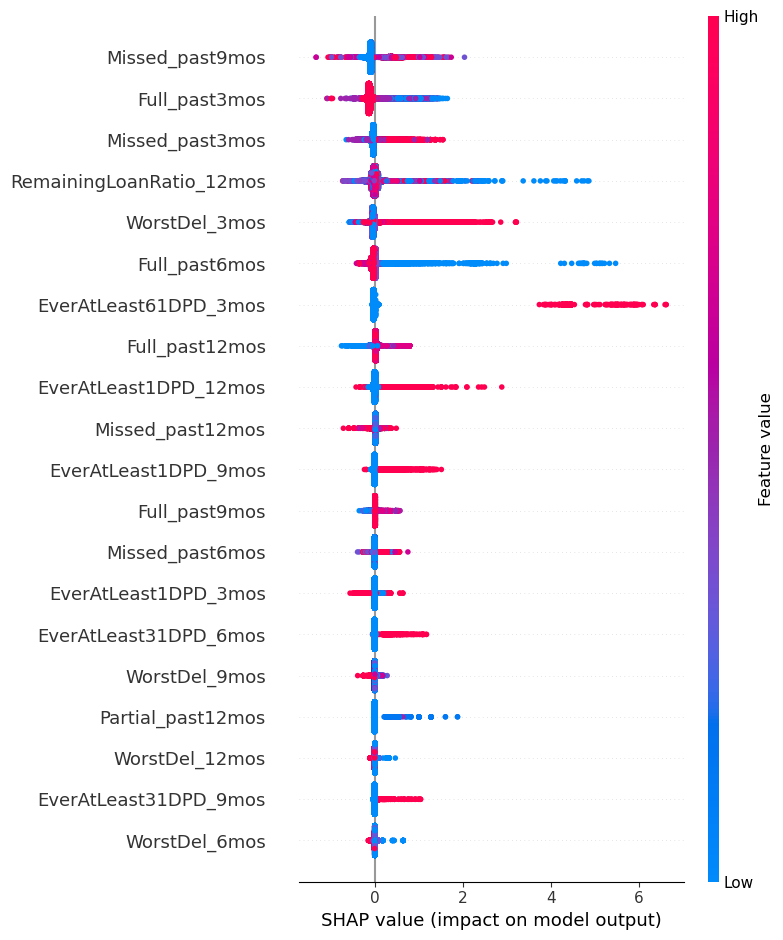

In [15]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train_split)
shap.summary_plot(shap_values, X_train_split)

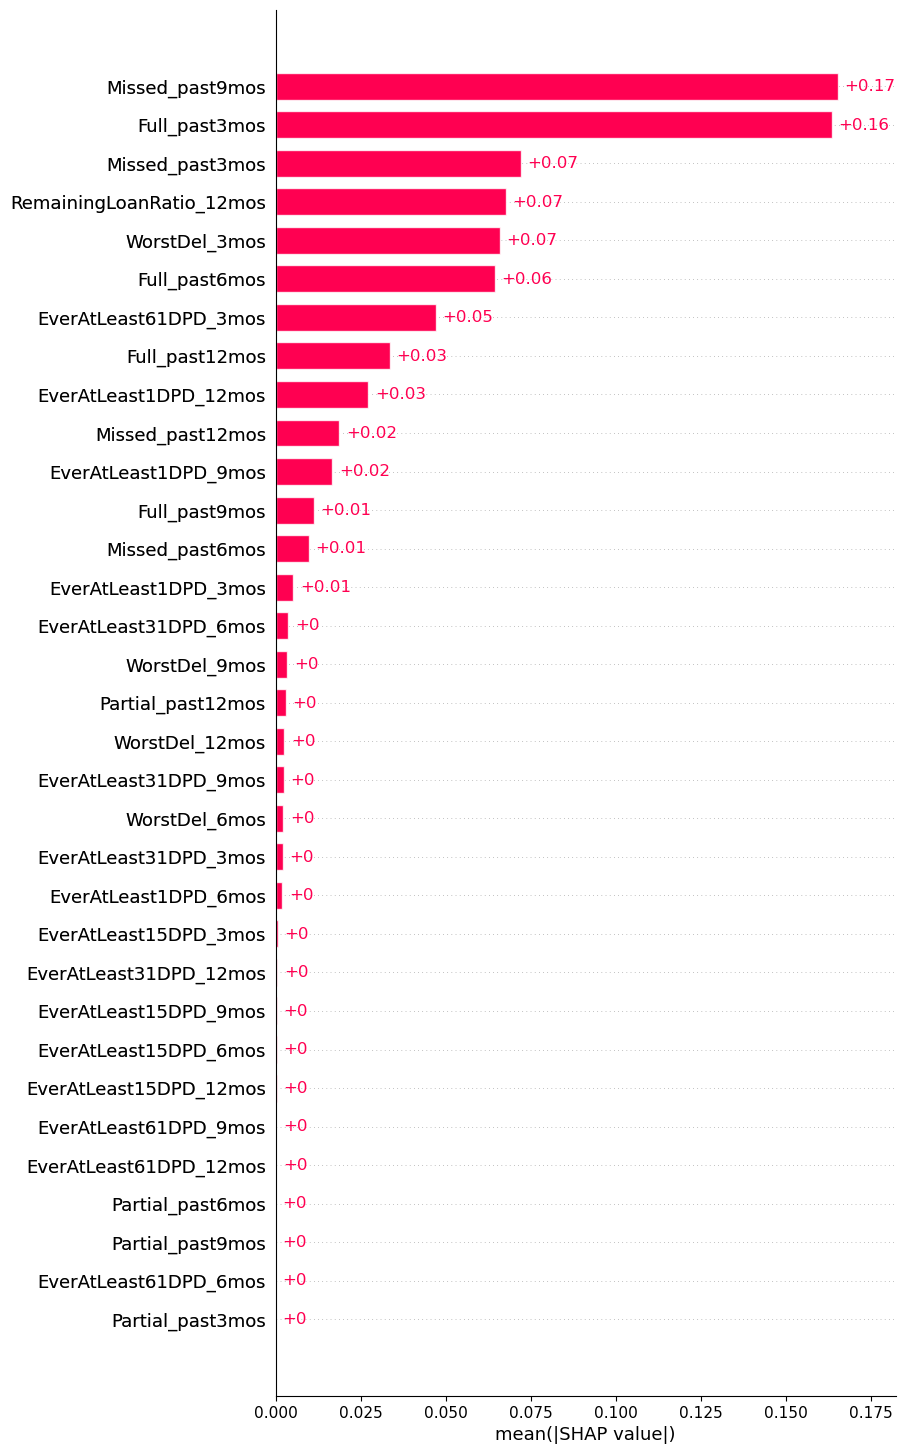

In [16]:
shap.plots.bar(shap_values, max_display=50)